[Prophet Toolbox Documentation](https://facebook.github.io/prophet/docs/saturating_forecasts.html)

# Import

## Path

In [1]:
import os
import sys

p = os.path.abspath('../')
if p not in sys.path:
    print('Adding {} path to system'.format(p))
    sys.path.append(p)
    


Adding C:\Cerebral\_MarioSandBox\Python\covid path to system


The [Epidemiological Data from the COVID-19 Outbreak in Canada](https://github.com/ishaberry/Covid19Canada) located in github.



In [77]:
import plotly# Complete Database
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

## Modules

In [2]:
from myFunctions.covid import covid as cvd
import myFunctions.myVis as myVis

In [3]:
import pandas as pd
import numpy as np

In [72]:
from utilities.EpiModel import *
import utilities.PDEparams as pde
from scipy.integrate import odeint

In [5]:
from scipy.integrate import solve_ivp
import optuna
optuna.logging.disable_default_handler()
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from datetime import timedelta

# Modeling Functions

In [6]:
def getPop(province='Ontario',p='C:\Cerebral\_MarioSandBox\Python\covid'):
    provinceDataPopFile = '\data\provincePop.csv'
    popData = pd.read_csv(p + provinceDataPopFile)
    popData = popData.set_index('province')    
    return popData.loc[province].population

In [22]:
# ODE Models
def sir(X,t,b,g):
    s,i,r=X
    
    ds=-b*(s*i)
    di=b*(s*i)-g*i
    dr=g*i
    return[ds,di,dr]

#Numeric solution of the model
def sol_sir(init,t,b,g):
    sol=odeint(sir,init,t,args=(b,g))
    return(sol)

In [66]:
def init_s():
    return 1-init_i()

def init_i():
    return df['I'][0]

def init_r():
    return 0

# Get Data

In [115]:
covidObject = cvd(cached=True)

Getting COVID data
cached


In [8]:
provToAnalyze = 'Ontario'
covidObject.getProcessedData(provToAnalyze)

In [9]:
# convert dictionary into dataframe
dfData = pd.DataFrame.from_dict(covidObject.dataProcess)
# convert date col to datetime pandas series
dfData['date'] = pd.to_datetime(dfData['date'])
# convert index to dates
dfData = dfData.set_index('date')

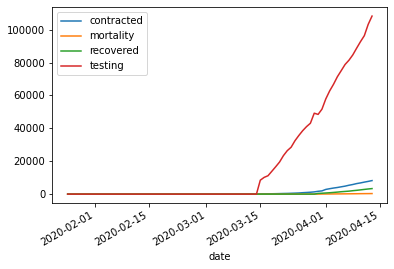

In [10]:
dfData.plot()

In [116]:
dfData.tail()

contracted  mortality  recovered  testing
date                                                 
2020-04-09        6397        233       2305    88698
2020-04-10        6804        269       2574    92673
2020-04-11        7294        290       2858    96321
2020-04-12        7727        303       3121   103165
2020-04-13        8221        333       3357   108230

In [12]:
provPop = getPop('Ontario')

# Trend Analysis

In this notebook we will lok at trending using [fbprophet 0.6](https://pypi.org/project/fbprophet/)

## Linear Trends in log transform

### Contracted

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


26   2020-03-06
51   2020-03-31
Name: ds, dtype: datetime64[ns]


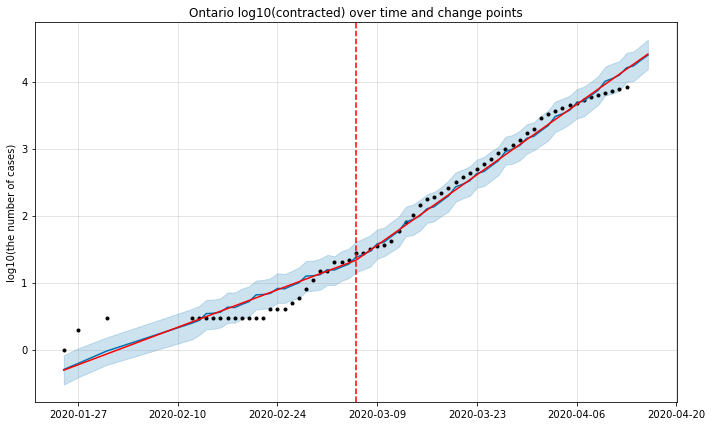

In [13]:
forecast = myVis.show_trend(df=dfData,
                name=provToAnalyze,
                typeToVis='contracted',
                n_changepoints=2,
               returnForcast=True,
               typeOfFit='linear')

There is a critical point on **2020-03-05** where the number of cases shot up.  Lets model everything after this change to identify more critical points and for the model to me more compartmentalized.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


16   2020-03-21
31   2020-04-05
Name: ds, dtype: datetime64[ns]


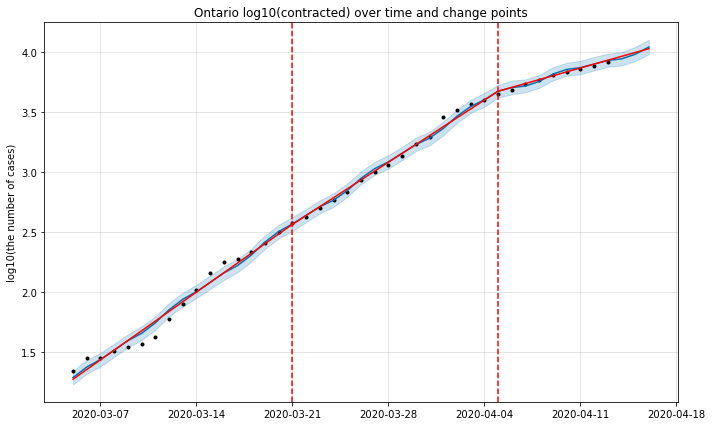

In [14]:
forecast = myVis.show_trend(df=dfData,
                name=provToAnalyze,
                typeToVis='contracted',
                n_changepoints=2,
               returnForcast=True,
               typeOfFit='linear',                           
                startDate='2020-03-05')

From the above critical points we see that there are 3 phases.

| Phase | Start Date (index) | End Date (index) |
|-------|--------------------|------------------|
| 1     | 2020-03-05 (25)    | 2020-03-20 (40)  |
| 2     | 2020-03-20 (40)    | 2020-04-04 (55)  |
| 3     | 2020-04-04 (55)    | today (:)        |

In [15]:
phase = [1,2,3]
phaseStart = [25,40,55]
phaseEnd = [40,55,len(dfData)]

critPhaseCases = []

for p,ps,pe in zip(phase,phaseStart,phaseEnd):
    dictPhase = {
        'phase':p,
        'phaseStart':ps,
        'phaseEnd':pe}
    critPhaseCases.append(dictPhase)

### Deaths

C:\Users\HP\Anaconda2\envs\mlPlaygroundPy36\lib\site-packages\pandas\core\series.py:679: RuntimeWarning:

divide by zero encountered in log10

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


26   2020-03-06
51   2020-03-31
Name: ds, dtype: datetime64[ns]


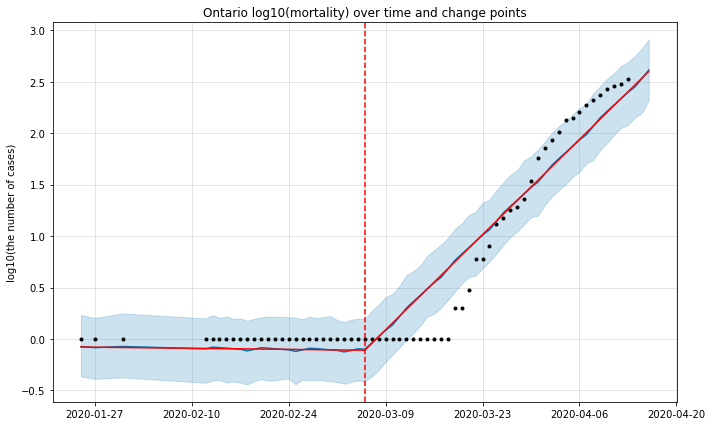

In [16]:
forecast = myVis.show_trend(df=dfData,
                name=provToAnalyze,
                typeToVis='mortality',
                n_changepoints=2,
                 returnForcast=True,
               typeOfFit='linear')

Change seems to occur more in 2020-03-18 so lets apply trend on that day instead of the beggining

In [17]:
dfData.iloc[38]

contracted      214
mortality         1
recovered         5
testing       13897
Name: 2020-03-18 00:00:00, dtype: int64

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


10   2020-03-28
20   2020-04-07
Name: ds, dtype: datetime64[ns]


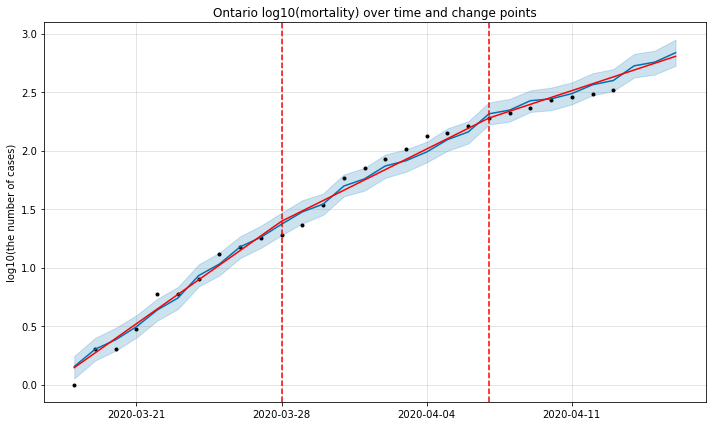

In [18]:
forecast = myVis.show_trend(df=dfData,
                name=provToAnalyze,
                typeToVis='mortality',
                n_changepoints=2,
                 returnForcast=True,
               typeOfFit='linear',
                startDate='2020-03-18')

Similar to the number of cases graph from the above critical points we see that there are 3 phases.

| Phase | Start Date (index) | End Date (index) |
|-------|--------------------|------------------|
| 1     | 2020-03-18 (38)    | 2020-03-28 (48)  |
| 2     | 2020-03-28 (48)    | 2020-04-06 (57)  |
| 3     | 2020-04-06 (57)    | today (:)        |

In [19]:
phaseStart = [38,48,57]
phaseEnd = [48,57,len(dfData)]

critPhaseDeath = []

for p,ps,pe in zip(phase,phaseStart,phaseEnd):
    dictPhase = {
        'phase':p,
        'phaseStart':ps,
        'phaseEnd':pe}
    critPhaseDeath.append(dictPhase)

# Modeling SIR

# SIR Model

### What is SIR model?
SIR model is a simple mathematical model to understand outbreak of infectious diseases.  
[The SIR epidemic model - Learning Scientific Programming with Python](https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/)

 * S: Susceptible (=All - Confirmed)
 * I: Infected (=Confirmed - Recovered - Deaths)
 * R: Recovered or fatal (=Recovered + Deaths)
 
**Note: THE FOLLOWING IMPLEMENTATION IS NOT THE GENERAL MODEL!**
Though R in SIR model is "Recovered and have immunity", the definition of **R here is Recovered or fatal**. This is because mortality rate cannot be ignored in the real COVID-19 data.

Model:  
$$S + I \overset{\beta}{\longrightarrow} 2I  $$
$$I \overset{\gamma}{\longrightarrow} R$$

$\beta$: Transmission/infection rate [1/min]  
$\gamma$: Recovery**(+Mortality)** rate [1/min]  

Ordinary Differential Equation (ODE):   
$\frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I$  
$\frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}\beta S I - \gamma I$  
$\frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I$  

Where $N=S+I+R$ is the total population, $T$ is the elapsed time from the start date.

### Non-dimensional SIR model
To simplify the model, we will remove the units of the variables from ODE.

Set 
$$(S, I, R) = N \times (x, y, z)$$ 
and 
$$(T, \beta, \gamma) = (\tau t, \tau^{-1} \rho, \tau^{-1} \sigma)$$


This results in the ODE: 

| $\frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y$          | $\frac{\mathrm{d}S}{\mathrm{d}t}= - \beta S I $         |
|--------------------------------------------------------|---------------------------------------------------------|
| $\frac{\mathrm{d}y}{\mathrm{d}t}= \rho x y - \sigma y$ | $\frac{\mathrm{d}I}{\mathrm{d}t}= \beta S I - \gamma I$ |
| $\frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y$            | $\frac{\mathrm{d}R}{\mathrm{d}t}= \gamma I$             |

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
$0 < (x, y, z, \rho, \sigma) < 1$  
$1\leq \tau \leq 1440$  

$\tau$ here is time in minutes and there are 1440 min in each day.

Basic reproduction number, Non-dimentional parameter, is defined as  
$$R_0 = \frac{\rho}{\sigma} = \frac{\beta}{\gamma}$$

Estimated Mean Values of $R_0$:  
$R_0$ means "the average number of secondary infections caused by an infected host" ([Infection Modeling — Part 1](https://towardsdatascience.com/infection-modeling-part-1-87e74645568a)).  
(Secondary data: [Van den Driessche, P., & Watmough, J. (2002).](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6002118))  
2.06: Zika in South America, 2015-2016  
1.51: Ebola in Guinea, 2014  
1.33: H1N1 influenza in South Africa, 2009  
3.5 : SARS in 2002-2003  
1.68: H2N2 influenza in US, 1957  
3.8 : Fall wave of 1918 Spanish influenza in Genova  
1.5 : Spring wave of 1918 Spanish influenza in Genova  

When $x=\frac{1}{R_0}$, $\frac{\mathrm{d}y}{\mathrm{d}t}=0$. This means that the max value of confirmed ($=I+R$) is $1-\frac{1}{R_0}$.

## 3 Phase Based on Contracted Cases

In [20]:
critPhaseCases

[{'phase': 1, 'phaseStart': 25, 'phaseEnd': 40},
 {'phase': 2, 'phaseStart': 40, 'phaseEnd': 55},
 {'phase': 3, 'phaseStart': 55, 'phaseEnd': 65}]

Lets first create the SIR model described above using [Bruno Goncalves](https://raw.githubusercontent.com/DataForScience/Epidemiology101/master/EpiModel.py) calculations

$$S + I \overset{\beta}{\longrightarrow} I  $$
$$I \overset{\gamma}{\longrightarrow} R$$

$\beta$: Transmission/infection rate [1/min]  
$\gamma$: Recovery**(+Mortality)** rate [1/min]  

Also recall that $R_0 = \frac{\beta}{\gamma}$ currently if we estimate that $R_0$ is 2.5 like others have said we can use this information to either varify our model or use it as a relative guideline to identify what values of $\beta$ or $\gamma$ we can choose.

Now comes that challenge of identifying the hyperparameters of $\beta$ and $\gamma$ for each of the segments so that we can do some estimation of the model and also forcasting.

In [82]:
dfData.tail()

contracted  mortality  recovered  testing
date                                                 
2020-04-09        6397        233       2305    88698
2020-04-10        6804        269       2574    92673
2020-04-11        7294        290       2858    96321
2020-04-12        7727        303       3121   103165
2020-04-13        8221        333       3357   108230

## Estimation

Now analyzing phase 1
     $beta$   $gamma$
0  0.327695  0.150999
Now analyzing phase 2
     $beta$   $gamma$
0  0.300151  0.124705
Now analyzing phase 3
     $beta$   $gamma$
0  0.300003  0.199979


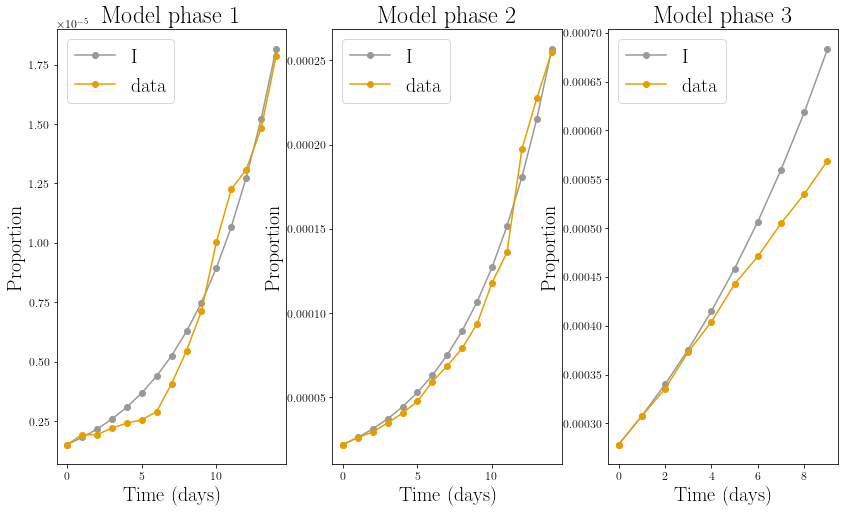

In [113]:
figNum = 1
fig1,ax=plt.subplots(1,3,figsize=(14,8))
for phase in critPhaseCases:
    print(f"Now analyzing phase {phase['phase']}")
    
    start = phase['phaseStart']
    fin = phase['phaseEnd']
    
    # get subData
    iData = dfData['contracted'].tolist()[start:fin]
    df = pd.DataFrame(range(len(iData)),columns=['t'])
    df['I'] = iData/provPop
    
    #Parameter estimation
    my_sir=pde.PDEmodel(df,
                        sir,
                        [init_s,init_i,init_r],
                        bounds=[(0.3,2),(1/14,1/5)],
                       param_names=[r'$beta$', r'$gamma$'], 
                        nvars=3, 
                        ndims=0, 
                        nreplicates=1, 
                        obsidx=[1], 
                        outfunc=None)
    
    my_sir.fit()
    my_sir.best_params
    
    bestPars_sir=my_sir.best_params
    bBsir=bestPars_sir['$beta$'][0]
    gBsir=bestPars_sir['$gamma$'][0]
    
    bestSol=odeint(sir,
               [init_s(),init_i(),init_r()],
               range(len(iData)),
               args=(bBsir,gBsir))
    #sol=odeint(sir,[shortMex.sum(axis=0),1,0],tMex,args=(bB,gB))
    S=bestSol.T[0]
    I=bestSol.T[1]
    R=bestSol.T[2]
    
    ax[phase['phase']-1].plot(range(len(iData)),I,'-o',label='I')
    ax[phase['phase']-1].plot(range(len(iData)),df['I'],'-o',label='data')
    ax[phase['phase']-1].set_title(f"Model phase {phase['phase']}")
    ax[phase['phase']-1].set_xlabel('Time (days)')
    ax[phase['phase']-1].set_ylabel('Proportion')
    ax[phase['phase']-1].legend()

everything looks to be modeling properly except for the last phase ... we may have to rethink this one ...

Lets look at other models before quiting on this one